In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt 
%matplotlib inline
plt.rc("font", size=14)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
# direct marketing campaigns (phone calls) of a Portuguese banking institution. 
# The classification goal is to predict whether the client will subscribe (1/0) to a term deposit (variable y)
data = pd.read_csv("banking.csv", header=0)
# отбрасываем пропущенные значения
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [6]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


Input variables

* age (numeric)
* job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
* marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)
* education (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
* default: has credit in default? (categorical: “no”, “yes”, “unknown”)
* housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
* loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
* contact: contact communication type (categorical: “cellular”, “telephone”)
* month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
* day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
* duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)
* emp.var.rate: employment variation rate — (numeric)
* cons.price.idx: consumer price index — (numeric)
* cons.conf.idx: consumer confidence index — (numeric)
* euribor3m: euribor 3 month rate — (numeric)
* nr.employed: number of employees — (numeric)

Predict variable (desired target):
y — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)

In [3]:
# уровни образования
data["education"].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [4]:
# группировка нескольких уровней базового образования в один
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [5]:
data["education"].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

## Изучение данных

In [6]:
data["y"].value_counts()

0    36548
1     4640
Name: y, dtype: int64

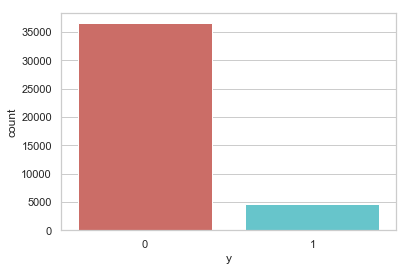

<Figure size 432x288 with 0 Axes>

In [7]:
sns.countplot(x="y", data=data, palette="hls")
plt.show()
plt.savefig("count_plot")

In [8]:
# проценты оформивших депозит
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])

pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Процент клиентов, НЕ оформивших депозит", pct_of_no_sub*100)

pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Процент клиентов, оформивших депозит", pct_of_sub*100)

Процент клиентов, НЕ оформивших депозит 88.73458288821988
Процент клиентов, оформивших депозит 11.265417111780131


In [9]:
data.groupby("y").mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [10]:
data.groupby("job").mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [11]:
data.groupby("marital").mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [12]:
data.groupby("education").mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


## Визуализация

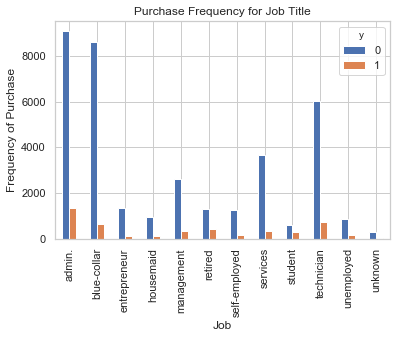

In [13]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

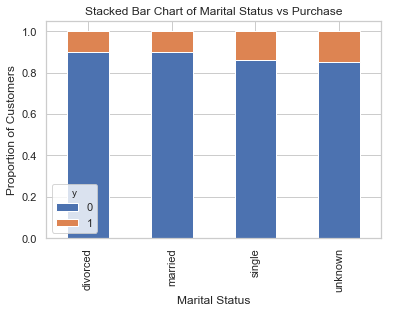

In [14]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

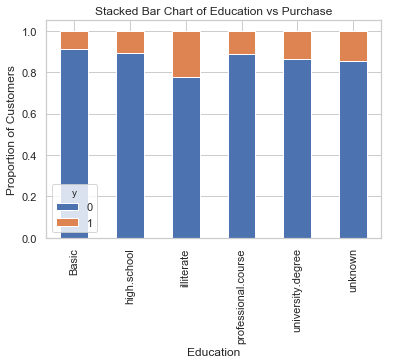

In [15]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

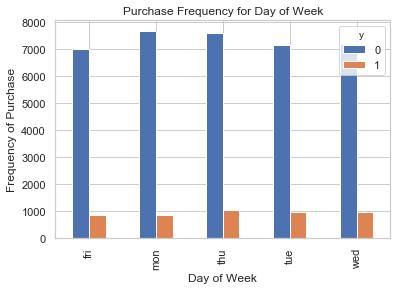

In [16]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

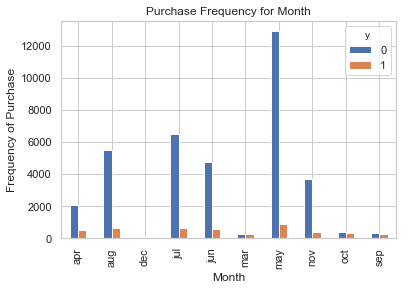

In [17]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

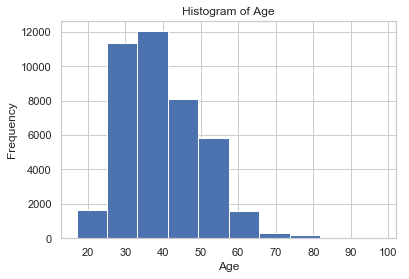

In [18]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

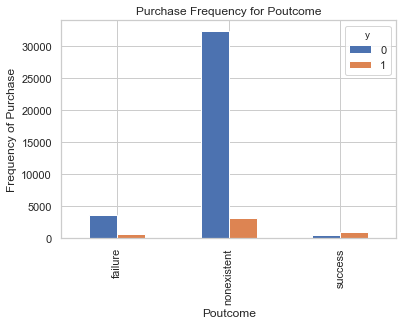

In [19]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

## Создание фиктивных переменных

In [20]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,...,0,0,0,0,1,0,0,0,1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,0,0,1,0,0,0,0,0,1,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,0,0,0,0,1,0,0,0,0,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,0,0,1,0,0,0,0,0,1,0
4,55,retired,married,Basic,no,yes,no,cellular,aug,fri,...,0,0,1,0,0,0,0,0,0,1


In [21]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [22]:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

## Over-sampling с использованием SMOTE

In [23]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
# разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

columns = X_train.columns
# выполнение oversampling
os_data_X, os_data_y = os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])



(28831, 61) (12357, 61) (28831, 1) (12357, 1)


F:\Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


## Recursive Feature Elimination

In [25]:
data_final_vars=data_final.columns.values.tolist()

y=['y']
X=[i for i in data_final_vars if i not in y]


In [26]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=20, verbose=1)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())

print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 61 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 60 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 59 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 58 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 57 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 56 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 55 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 54 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 53 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 52 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 51 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 50 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 49 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 48 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 47 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 46 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 45 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 44 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 43 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 42 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 41 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 40 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 39 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 38 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 37 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 36 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 35 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 34 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 33 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 32 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 31 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 30 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 29 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 28 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 27 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 26 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 25 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 24 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 23 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 22 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 21 features.


F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[False False False False False False False False  True False False  True
 False  True False False  True  True False  True False False False False
 False  True False False  True False False False  True  True False False
 False False False False False  True  True  True False False False False
  True  True  True  True  True False False False False False  True False
  True]
[37 35 24 38  7 10 20 33  1 31  5  1  4  1  2 30  1  1 27  1  3  8 17 18
 13  1 11 15  1 14 19 16  1  1 42 25 39 34 29 36 32  1  1  1  6 23 40 22
  1  1  1  1  1 28  9 26 41 21  1 12  1]


In [43]:
print(rfe.n_features_ )
print(rfe.support_)
print(rfe.ranking_)

20
[False False False False False False False False  True False False  True
 False  True False False  True  True False  True False False False False
 False  True False False  True False False False  True  True False False
 False False False False False  True  True  True False False False False
  True  True  True  True  True False False False False False  True False
  True]
[37 35 24 38  7 10 20 33  1 31  5  1  4  1  2 30  1  1 27  1  3  8 17 18
 13  1 11 15  1 14 19 16  1  1 42 25 39 34 29 36 32  1  1  1  6 23 40 22
  1  1  1  1  1 28  9 26 41 21  1 12  1]


In [27]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

## Построение модели

In [28]:
import statsmodels.api as sm

logit_model = sm.Logit(y,X)
result = logit_model.fit()

print(result.summary2())

         Current function value: 0.545904
         Iterations: 35
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.212     
Dependent Variable:      y                    AIC:                  55868.4619
Date:                    2018-12-10 18:58     BIC:                  56045.3060
No. Observations:        51134                Log-Likelihood:       -27914.   
Df Model:                19                   LL-Null:              -35443.   
Df Residuals:            51114                LLR p-value:          0.0000    
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                      Coef.    Std.Err.    z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
euribor3m         

F:\Programs\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.555890
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.198     
Dependent Variable:   y                 AIC:               56881.7793
Date:                 2018-12-10 19:00  BIC:               57023.2546
No. Observations:     51134             Log-Likelihood:    -28425.   
Df Model:             15                LL-Null:           -35443.   
Df Residuals:         51118             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m            -0.4488   0.0074 -60.6838 0.0000 -0.4632 -0.4343
job_blue-collar 

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

F:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6124 1542]
 [2505 5170]]


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      7666
           1       0.77      0.67      0.72      7675

   micro avg       0.74      0.74      0.74     15341
   macro avg       0.74      0.74      0.74     15341
weighted avg       0.74      0.74      0.74     15341



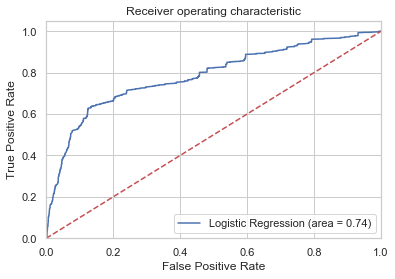

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()